# Comprehensive Hospital Data Analysis
## Multi-Dimensional Visualization: Environmental Factors, Events & Resource Requirements

This notebook analyzes relationships between:
- **Environmental Data**: Air Quality, Weather
- **Health Events**: Epidemic Surveillance, Festivals/Events
- **Hospital Resources**: Staff Availability, Supply Inventory
- **Patient Demand**: Visit patterns and requirements

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Data Loading
Load all CSV files generated by the hospital data generator

In [2]:
# Define data directory
DATA_DIR = './hospital_data_csv/'

# Load all tables
print("Loading data...")

locations = pd.read_csv(f'{DATA_DIR}locations.csv')
hospitals = pd.read_csv(f'{DATA_DIR}hospitals.csv')
departments = pd.read_csv(f'{DATA_DIR}departments.csv')
staff = pd.read_csv(f'{DATA_DIR}staff.csv')
weather_data = pd.read_csv(f'{DATA_DIR}weather_data.csv', parse_dates=['record_date'])
air_quality_data = pd.read_csv(f'{DATA_DIR}air_quality_data.csv', parse_dates=['record_date'])
events = pd.read_csv(f'{DATA_DIR}events.csv', parse_dates=['start_date', 'end_date'])
epidemic_surveillance = pd.read_csv(f'{DATA_DIR}epidemic_surveillance.csv', parse_dates=['date'])
patient_visits = pd.read_csv(f'{DATA_DIR}patient_visits.csv', parse_dates=['visit_date', 'visit_dttm', 'admission_dttm', 'discharge_dttm'])
diagnoses = pd.read_csv(f'{DATA_DIR}diagnoses.csv', parse_dates=['diagnosis_time'])
staff_availability = pd.read_csv(f'{DATA_DIR}staff_availability.csv', parse_dates=['snapshot_date', 'snapshot_ts'])
supply_inventory = pd.read_csv(f'{DATA_DIR}supply_inventory.csv', parse_dates=['snapshot_date'])

print("\n✓ All data loaded successfully!")
print(f"\nData Summary:")
print(f"  Locations: {len(locations)}")
print(f"  Hospitals: {len(hospitals)}")
print(f"  Departments: {len(departments)}")
print(f"  Staff: {len(staff)}")
print(f"  Patient Visits: {len(patient_visits):,}")
print(f"  Diagnoses: {len(diagnoses):,}")
print(f"  Weather Records: {len(weather_data):,}")
print(f"  Air Quality Records: {len(air_quality_data):,}")
print(f"  Events: {len(events)}")
print(f"  Epidemic Surveillance: {len(epidemic_surveillance):,}")

Loading data...

✓ All data loaded successfully!

Data Summary:
  Locations: 5
  Hospitals: 13
  Departments: 98
  Staff: 1950
  Patient Visits: 3,223,608
  Diagnoses: 4,352,439
  Weather Records: 5,285
  Air Quality Records: 5,285
  Events: 52
  Epidemic Surveillance: 4,251


## 2. Data Preparation & Aggregation
Merge data and create aggregated views by hospital and city

In [3]:
# Merge hospitals with locations to get city information
hospitals_with_location = hospitals.merge(locations, on='location_id', how='left')

# Display hospitals by city
print("Hospitals by City:")
print(hospitals_with_location.groupby('city')['hospital_name'].count())

# Get unique cities for filtering
cities = hospitals_with_location['city'].unique()
print(f"\nCities: {', '.join(cities)}")

Hospitals by City:
city
Mumbai    6
Nashik    2
Pune      3
Thane     2
Name: hospital_name, dtype: int64

Cities: Mumbai, Thane, Pune, Nashik


In [4]:
# Aggregate patient visits by date and hospital
daily_visits = patient_visits.groupby(['visit_date', 'hospital_id']).agg({
    'visit_id': 'count',
    'severity_level': 'mean',
    'admission_flag': 'sum',
    'age': 'mean'
}).reset_index()

daily_visits.columns = ['date', 'hospital_id', 'patient_count', 'avg_severity', 'admissions', 'avg_age']

# Merge with hospital info
daily_visits = daily_visits.merge(hospitals_with_location[['hospital_id', 'hospital_name', 'city', 'location_id']], on='hospital_id')

print("Daily visits aggregated:")
print(daily_visits.head())

Daily visits aggregated:
        date  hospital_id  patient_count  avg_severity  admissions    avg_age  \
0 2022-01-01            1            146      2.328767          11  37.479452   
1 2022-01-01            2            164      2.359756           9  35.609756   
2 2022-01-01            3            246      2.426829          29  35.634146   
3 2022-01-01            4            203      2.330049          28  32.827586   
4 2022-01-01            5            241      2.385892          38  35.751037   

                             hospital_name    city  location_id  
0    Metro Medical Center - Mumbai Central  Mumbai            1  
1       District Hospital - Mumbai Central  Mumbai            1  
2         Apollo Hospital - Mumbai Central  Mumbai            1  
3      Lilavati Hospital - Mumbai Suburban  Mumbai            2  
4  City General Hospital - Mumbai Suburban  Mumbai            2  


## 3. Calculate Required Resources
Calculate required staff and inventory based on patient demand

In [5]:
# Calculate required staff based on patient volume
# Rule of thumb: 1 doctor per 15 patients, 1 nurse per 5 patients, 1 tech per 20 patients

daily_visits['required_doctors'] = np.ceil(daily_visits['patient_count'] / 15).astype(int)
daily_visits['required_nurses'] = np.ceil(daily_visits['patient_count'] / 5).astype(int)
daily_visits['required_technicians'] = np.ceil(daily_visits['patient_count'] / 20).astype(int)
daily_visits['total_required_staff'] = daily_visits['required_doctors'] + daily_visits['required_nurses'] + daily_visits['required_technicians']

print("Required staff calculated based on patient volume")
print(daily_visits[['date', 'hospital_name', 'patient_count', 'required_doctors', 'required_nurses', 'required_technicians']].head(10))

Required staff calculated based on patient volume
        date                            hospital_name  patient_count  \
0 2022-01-01    Metro Medical Center - Mumbai Central            146   
1 2022-01-01       District Hospital - Mumbai Central            164   
2 2022-01-01         Apollo Hospital - Mumbai Central            246   
3 2022-01-01      Lilavati Hospital - Mumbai Suburban            203   
4 2022-01-01  City General Hospital - Mumbai Suburban            241   
5 2022-01-01   Metro Medical Center - Mumbai Suburban            163   
6 2022-01-01                District Hospital - Thane            143   
7 2022-01-01                  Apollo Hospital - Thane            229   
8 2022-01-01                 Lilavati Hospital - Pune            171   
9 2022-01-01             City General Hospital - Pune            199   

   required_doctors  required_nurses  required_technicians  
0                10               30                     8  
1                11               3

In [6]:
# Aggregate staff availability by date and hospital
staff_daily = staff_availability.groupby(['snapshot_date', 'hospital_id']).agg({
    'doctors_available': 'sum',
    'nurses_available': 'sum',
    'technicians_available': 'sum'
}).reset_index()

staff_daily.columns = ['date', 'hospital_id', 'available_doctors', 'available_nurses', 'available_technicians']
staff_daily['total_available_staff'] = staff_daily['available_doctors'] + staff_daily['available_nurses'] + staff_daily['available_technicians']

# Merge with daily visits to compare available vs required
staff_comparison = daily_visits.merge(staff_daily, on=['date', 'hospital_id'], how='left')

print("Staff availability vs requirements:")
print(staff_comparison[['date', 'hospital_name', 'total_available_staff', 'total_required_staff']].head(10))

Staff availability vs requirements:
        date                            hospital_name  total_available_staff  \
0 2022-01-01    Metro Medical Center - Mumbai Central                    309   
1 2022-01-01       District Hospital - Mumbai Central                    408   
2 2022-01-01         Apollo Hospital - Mumbai Central                    413   
3 2022-01-01      Lilavati Hospital - Mumbai Suburban                    342   
4 2022-01-01  City General Hospital - Mumbai Suburban                    323   
5 2022-01-01   Metro Medical Center - Mumbai Suburban                    263   
6 2022-01-01                District Hospital - Thane                    461   
7 2022-01-01                  Apollo Hospital - Thane                    267   
8 2022-01-01                 Lilavati Hospital - Pune                    361   
9 2022-01-01             City General Hospital - Pune                    292   

   total_required_staff  
0                    48  
1                    53  
2    

In [7]:
# Calculate required inventory based on patient visits
# Assumptions: Each patient needs ~10 masks, ~5 gloves, ~2 syringes, etc.

# Aggregate inventory by date and hospital
inventory_daily = supply_inventory.groupby(['snapshot_date', 'hospital_id', 'item_code']).agg({
    'qty_on_hand': 'first',
    'item_name': 'first'
}).reset_index()

# Calculate total inventory value (simplified - count of all items)
inventory_summary = inventory_daily.groupby(['snapshot_date', 'hospital_id']).agg({
    'qty_on_hand': 'sum'
}).reset_index()
inventory_summary.columns = ['date', 'hospital_id', 'total_inventory_qty']

# Calculate required inventory (simplified: 50 units per patient)
daily_visits['required_inventory'] = daily_visits['patient_count'] * 50

# Merge inventory data
inventory_comparison = daily_visits.merge(inventory_summary, on=['date', 'hospital_id'], how='left')

print("Inventory levels vs requirements:")
print(inventory_comparison[['date', 'hospital_name', 'total_inventory_qty', 'required_inventory']].head(10))

Inventory levels vs requirements:
        date                            hospital_name  total_inventory_qty  \
0 2022-01-01    Metro Medical Center - Mumbai Central               146487   
1 2022-01-01       District Hospital - Mumbai Central               145820   
2 2022-01-01         Apollo Hospital - Mumbai Central               146534   
3 2022-01-01      Lilavati Hospital - Mumbai Suburban               146289   
4 2022-01-01  City General Hospital - Mumbai Suburban               145869   
5 2022-01-01   Metro Medical Center - Mumbai Suburban               146284   
6 2022-01-01                District Hospital - Thane               146185   
7 2022-01-01                  Apollo Hospital - Thane               146865   
8 2022-01-01                 Lilavati Hospital - Pune               145842   
9 2022-01-01             City General Hospital - Pune               146152   

   required_inventory  
0                7300  
1                8200  
2               12300  
3          

## 4. Prepare Environmental & Event Data
Merge environmental factors and events for visualization

In [8]:
# Merge weather and air quality data
environmental_data = weather_data.merge(
    air_quality_data, 
    left_on=['location_id', 'record_date'], 
    right_on=['location_id', 'record_date'],
    how='outer'
)

# Add location info
environmental_data = environmental_data.merge(locations[['location_id', 'city']], on='location_id')

print("Environmental data prepared:")
print(environmental_data.head())

Environmental data prepared:
   location_id record_date  temperature_avg  temperature_min  temperature_max  \
0            1  2022-01-01            26.49            22.03            31.69   
1            1  2022-01-02            24.30            21.18            30.03   
2            1  2022-01-03            23.59            20.23            27.96   
3            1  2022-01-04            19.26            15.40            23.84   
4            1  2022-01-05            22.28            18.36            27.85   

   humidity_percent  rainfall_mm  wind_speed_kmh  aqi_level    pm25    pm10  \
0             58.62          0.0           13.83        214   80.78  120.01   
1             75.79          0.0           18.84        182   69.11  138.55   
2             65.43          0.0           16.21        179   74.09  137.79   
3             49.87          0.0           16.57        156   31.85  130.56   
4             45.88          0.0           15.34        225  103.37  109.10   

     no2 

In [9]:
# Prepare epidemic data with location info
epidemic_with_location = epidemic_surveillance.merge(locations[['location_id', 'city']], on='location_id')

# Aggregate epidemic cases by date and city
epidemic_daily = epidemic_with_location.groupby(['date', 'city']).agg({
    'confirmed_cases': 'sum',
    'suspected_cases': 'sum',
    'deaths': 'sum'
}).reset_index()

print("Epidemic surveillance data prepared:")
print(epidemic_daily.head())

Epidemic surveillance data prepared:
        date    city  confirmed_cases  suspected_cases  deaths
0 2022-01-01  Mumbai                0                0       0
1 2022-01-01  Nashik               51              119       2
2 2022-01-01   Thane                4                7       0
3 2022-01-02  Mumbai               15               38       0
4 2022-01-02    Pune                4                9       0


## 5. Comprehensive Visualization by City
Create multi-panel plots showing all relationships

In [10]:
def plot_comprehensive_analysis(city_name, hospital_name=None):
    """
    Create comprehensive multi-panel visualization for a specific city/hospital
    """
    # Filter data for the selected city
    city_env = environmental_data[environmental_data['city'] == city_name].copy()
    city_epidemic = epidemic_daily[epidemic_daily['city'] == city_name].copy()
    
    # Get location_id for this city
    location_id = locations[locations['city'] == city_name]['location_id'].iloc[0]
    city_events = events[events['location_id'] == location_id].copy()
    
    # Filter hospital data
    if hospital_name:
        city_staff = staff_comparison[staff_comparison['hospital_name'] == hospital_name].copy()
        city_inventory = inventory_comparison[inventory_comparison['hospital_name'] == hospital_name].copy()
        title_suffix = f" - {hospital_name}"
    else:
        # Aggregate all hospitals in the city
        city_hospitals = hospitals_with_location[hospitals_with_location['city'] == city_name]['hospital_id'].tolist()
        city_staff = staff_comparison[staff_comparison['hospital_id'].isin(city_hospitals)].groupby('date').agg({
            'total_available_staff': 'sum',
            'total_required_staff': 'sum',
            'patient_count': 'sum'
        }).reset_index()
        city_inventory = inventory_comparison[inventory_comparison['hospital_id'].isin(city_hospitals)].groupby('date').agg({
            'total_inventory_qty': 'sum',
            'required_inventory': 'sum'
        }).reset_index()
        title_suffix = " - All Hospitals"
    
    # Create figure with subplots
    fig, axes = plt.subplots(6, 1, figsize=(16, 24))
    fig.suptitle(f'Comprehensive Hospital Analysis: {city_name}{title_suffix}', fontsize=20, fontweight='bold', y=0.995)
    
    # 1. Air Quality Index
    ax1 = axes[0]
    ax1.plot(city_env['record_date'], city_env['aqi_level'], color='#e74c3c', linewidth=2, label='AQI Level')
    ax1.fill_between(city_env['record_date'], city_env['aqi_level'], alpha=0.3, color='#e74c3c')
    ax1.axhline(y=100, color='orange', linestyle='--', alpha=0.5, label='Moderate Threshold')
    ax1.axhline(y=150, color='red', linestyle='--', alpha=0.5, label='Unhealthy Threshold')
    ax1.set_ylabel('AQI Level', fontsize=12, fontweight='bold')
    ax1.set_title('Air Quality Index Over Time', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Weather Data (Temperature & Humidity)
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    ax2.plot(city_env['record_date'], city_env['temperature_avg'], color='#3498db', linewidth=2, label='Avg Temperature')
    ax2.fill_between(city_env['record_date'], city_env['temperature_min'], city_env['temperature_max'], 
                      alpha=0.2, color='#3498db', label='Temp Range')
    ax2_twin.plot(city_env['record_date'], city_env['humidity_percent'], color='#2ecc71', linewidth=2, 
                  linestyle='--', label='Humidity %', alpha=0.7)
    
    ax2.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold', color='#3498db')
    ax2_twin.set_ylabel('Humidity (%)', fontsize=12, fontweight='bold', color='#2ecc71')
    ax2.set_title('Weather Conditions: Temperature & Humidity', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # 3. Epidemic Surveillance
    ax3 = axes[2]
    if len(city_epidemic) > 0:
        ax3.bar(city_epidemic['date'], city_epidemic['confirmed_cases'], color='#9b59b6', alpha=0.6, label='Confirmed Cases')
        ax3.bar(city_epidemic['date'], city_epidemic['suspected_cases'], color='#f39c12', alpha=0.4, label='Suspected Cases')
    ax3.set_ylabel('Case Count', fontsize=12, fontweight='bold')
    ax3.set_title('Epidemic Surveillance: Disease Cases', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # 4. Events Overlay on Patient Visits
    ax4 = axes[3]
    if hospital_name:
        ax4.plot(city_staff['date'], city_staff['patient_count'], color='#1abc9c', linewidth=2, label='Patient Visits')
    else:
        ax4.plot(city_staff['date'], city_staff['patient_count'], color='#1abc9c', linewidth=2, label='Total Patient Visits')
    
    # Mark events as vertical lines and dots
    for _, event in city_events.iterrows():
        event_date = event['start_date']
        ax4.axvline(x=event_date, color='red', alpha=0.3, linestyle=':', linewidth=2)
        ax4.scatter([event_date], [city_staff[city_staff['date'] == event_date]['patient_count'].max() if len(city_staff[city_staff['date'] == event_date]) > 0 else 0], 
                   color='red', s=100, marker='o', zorder=5, label=event['event_name'] if _ == 0 else '')
    
    ax4.set_ylabel('Patient Count', fontsize=12, fontweight='bold')
    ax4.set_title('Patient Visits with Events Marked', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    # 5. Staff Availability vs Required
    ax5 = axes[4]
    ax5.plot(city_staff['date'], city_staff['total_available_staff'], color='#27ae60', linewidth=2.5, 
             label='Available Staff', marker='o', markersize=3, markevery=10)
    ax5.plot(city_staff['date'], city_staff['total_required_staff'], color='#e67e22', linewidth=2.5, 
             label='Required Staff', marker='s', markersize=3, markevery=10, linestyle='--')
    
    # Fill gap between lines
    ax5.fill_between(city_staff['date'], city_staff['total_available_staff'], city_staff['total_required_staff'], 
                      where=(city_staff['total_available_staff'] >= city_staff['total_required_staff']), 
                      color='green', alpha=0.2, label='Surplus')
    ax5.fill_between(city_staff['date'], city_staff['total_available_staff'], city_staff['total_required_staff'], 
                      where=(city_staff['total_available_staff'] < city_staff['total_required_staff']), 
                      color='red', alpha=0.2, label='Shortage')
    
    ax5.set_ylabel('Staff Count', fontsize=12, fontweight='bold')
    ax5.set_title('Staff Availability vs Requirements', fontsize=14, fontweight='bold')
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    
    # 6. Supply Inventory vs Required
    ax6 = axes[5]
    ax6.plot(city_inventory['date'], city_inventory['total_inventory_qty'], color='#2980b9', linewidth=2.5, 
             label='Available Inventory', marker='o', markersize=3, markevery=10)
    ax6.plot(city_inventory['date'], city_inventory['required_inventory'], color='#c0392b', linewidth=2.5, 
             label='Required Inventory', marker='s', markersize=3, markevery=10, linestyle='--')
    
    # Fill gap between lines
    ax6.fill_between(city_inventory['date'], city_inventory['total_inventory_qty'], city_inventory['required_inventory'], 
                      where=(city_inventory['total_inventory_qty'] >= city_inventory['required_inventory']), 
                      color='green', alpha=0.2, label='Surplus')
    ax6.fill_between(city_inventory['date'], city_inventory['total_inventory_qty'], city_inventory['required_inventory'], 
                      where=(city_inventory['total_inventory_qty'] < city_inventory['required_inventory']), 
                      color='red', alpha=0.2, label='Shortage')
    
    ax6.set_ylabel('Inventory Quantity', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax6.set_title('Supply Inventory vs Requirements', fontsize=14, fontweight='bold')
    ax6.legend(loc='upper right')
    ax6.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function created")

✓ Visualization function created


## 6. Generate Visualizations for Each City

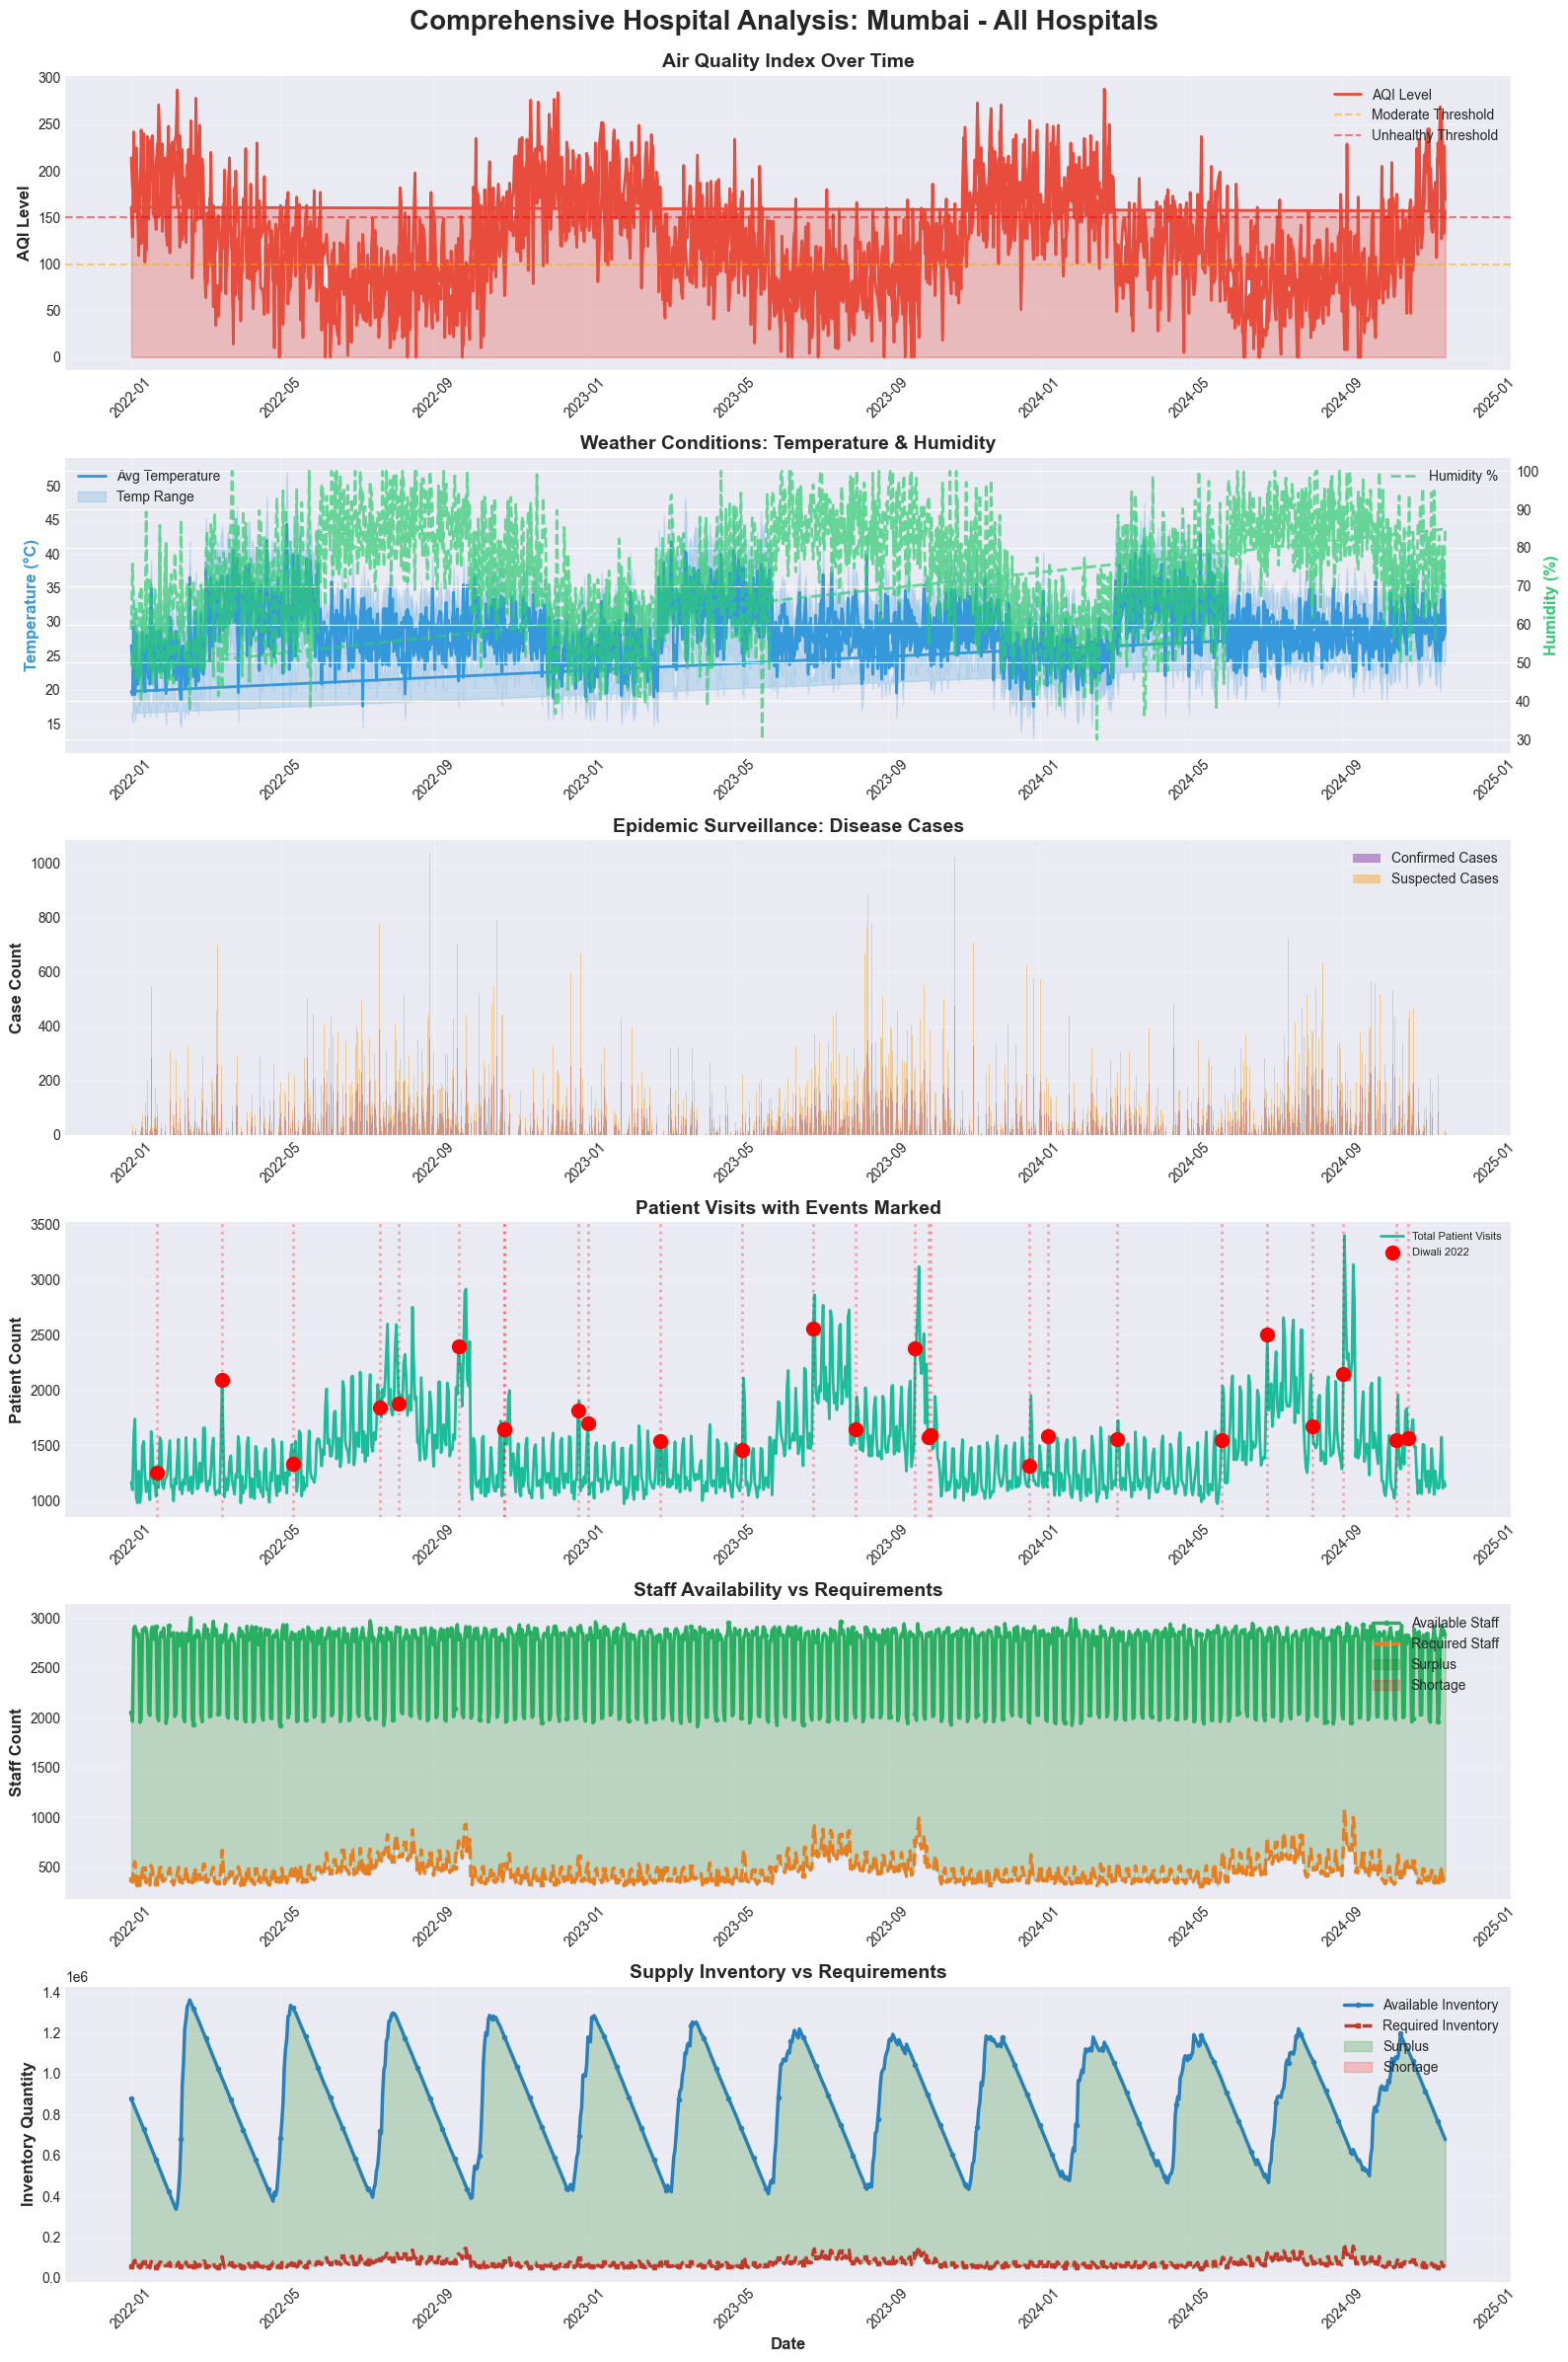

In [11]:
# Plot for Mumbai Central - All Hospitals
plot_comprehensive_analysis('Mumbai')

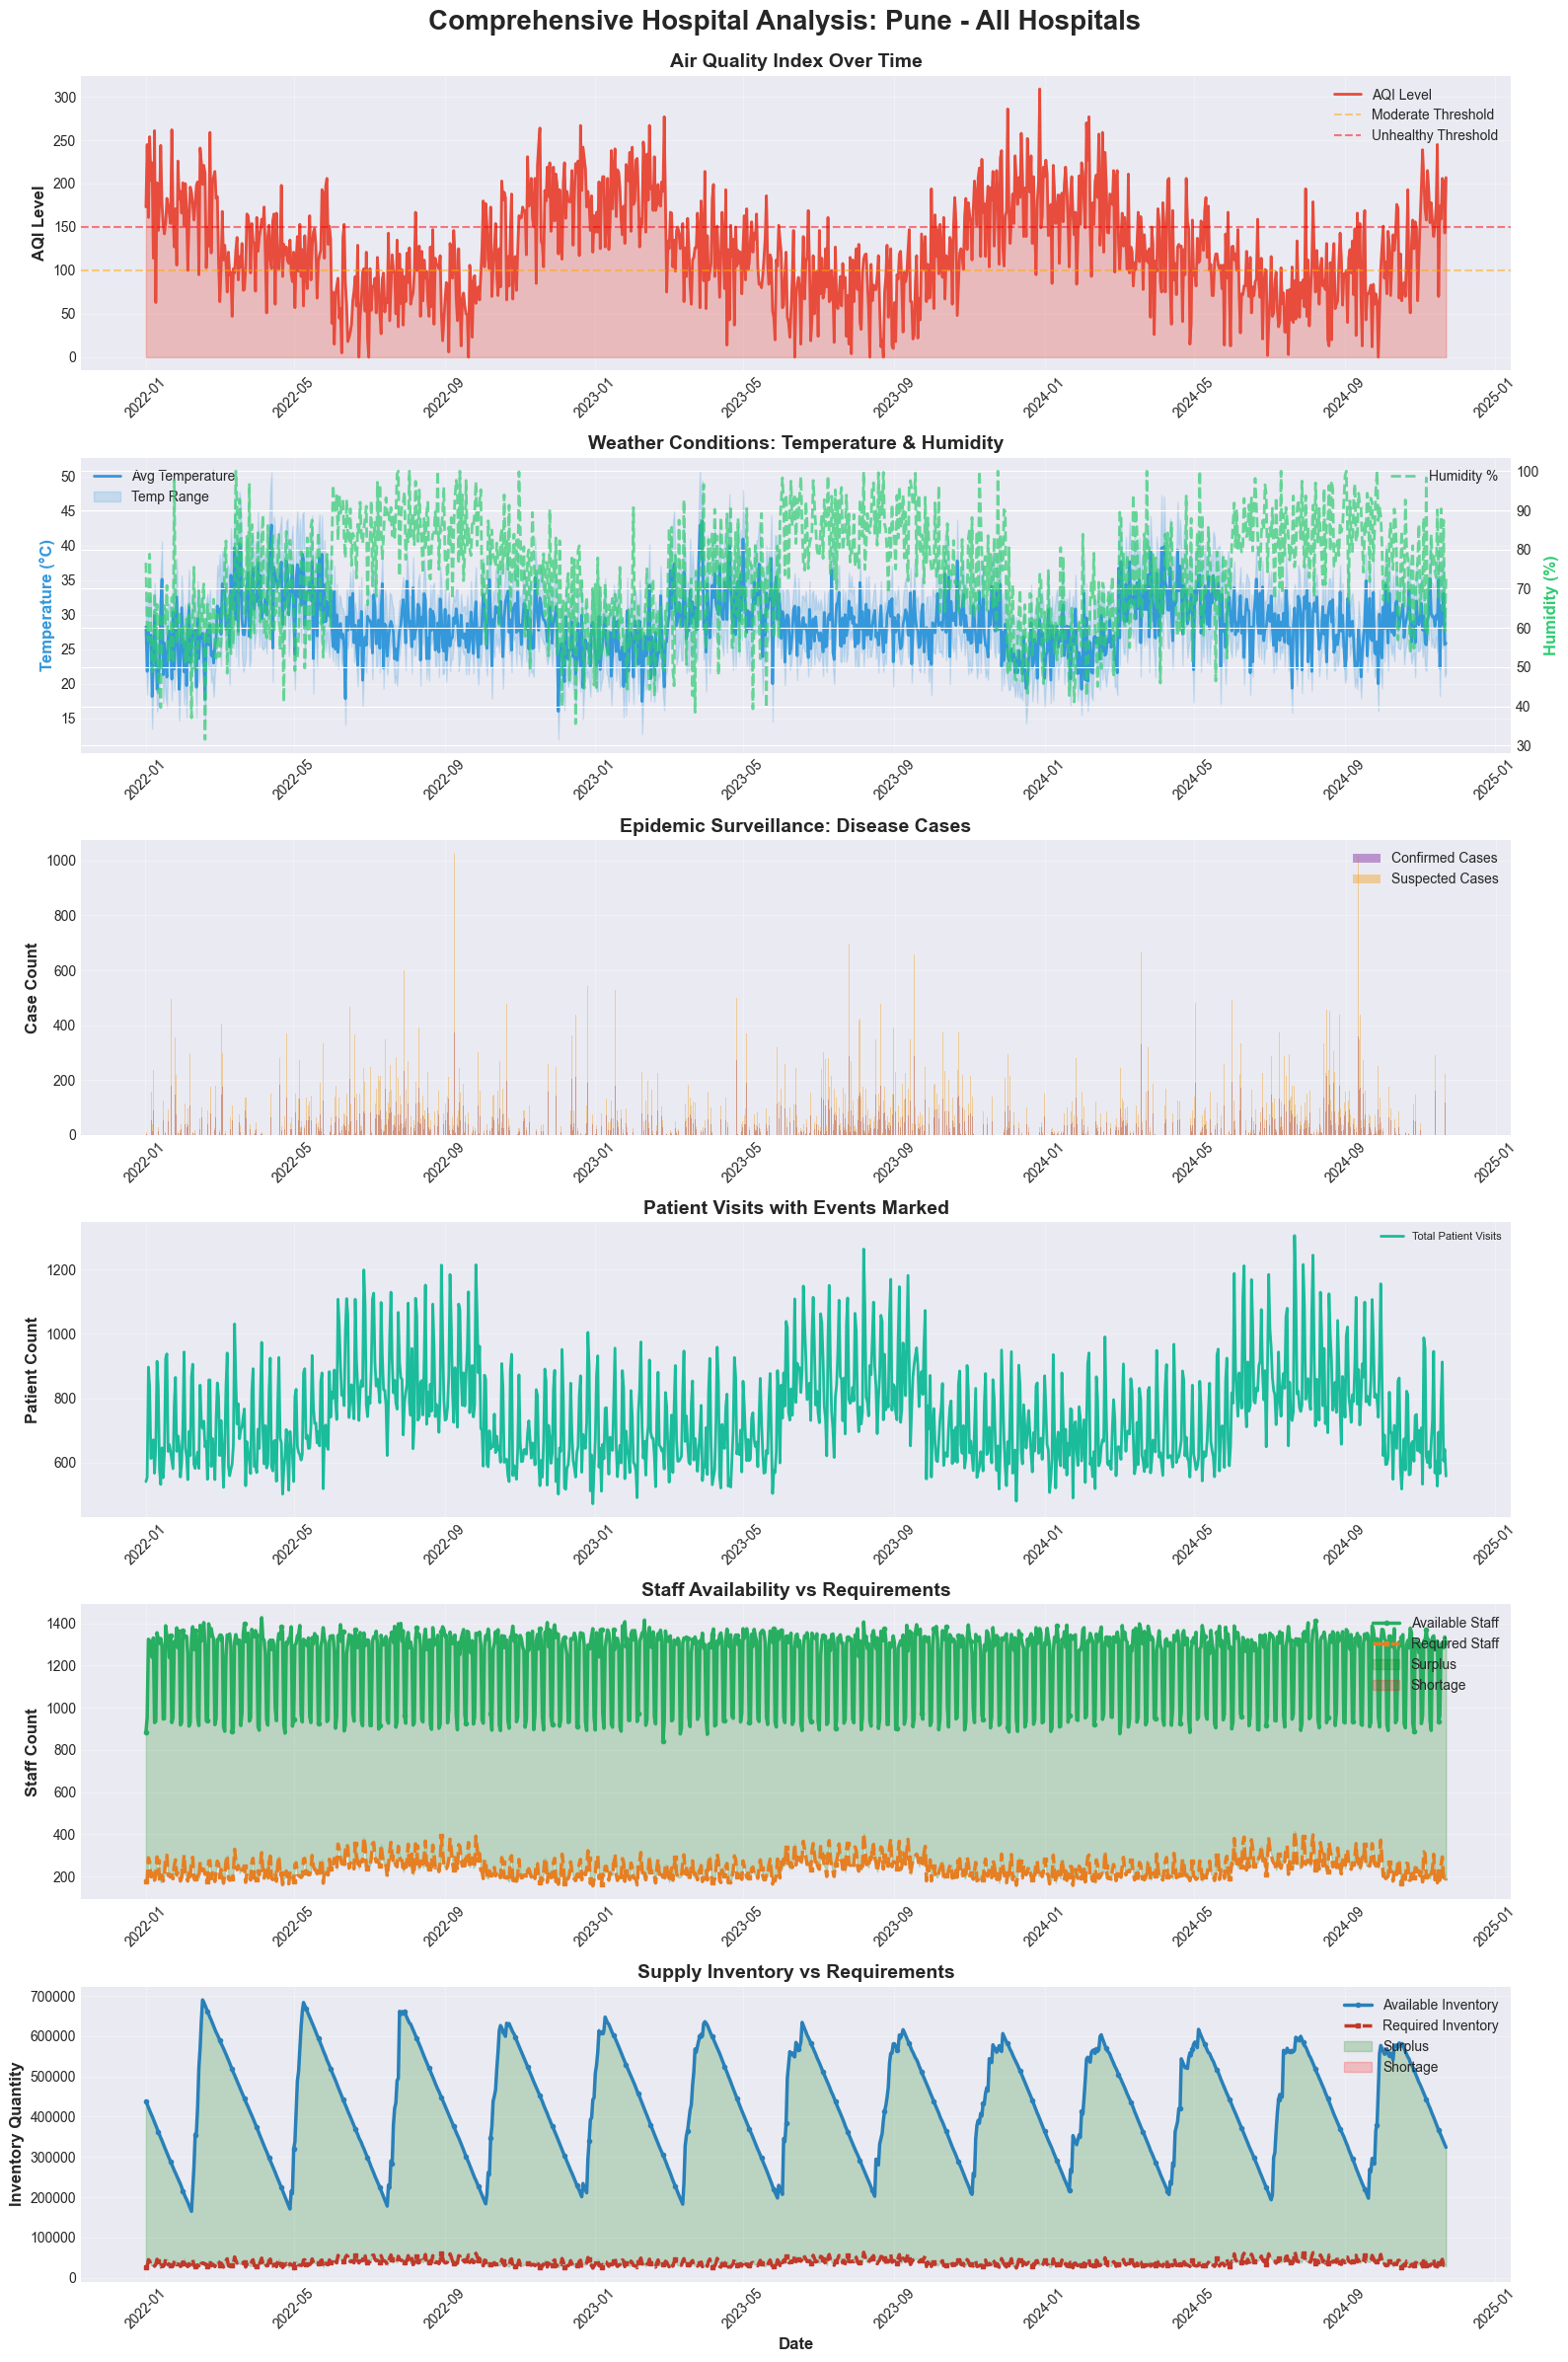

In [12]:
# Plot for Pune - All Hospitals
plot_comprehensive_analysis('Pune')

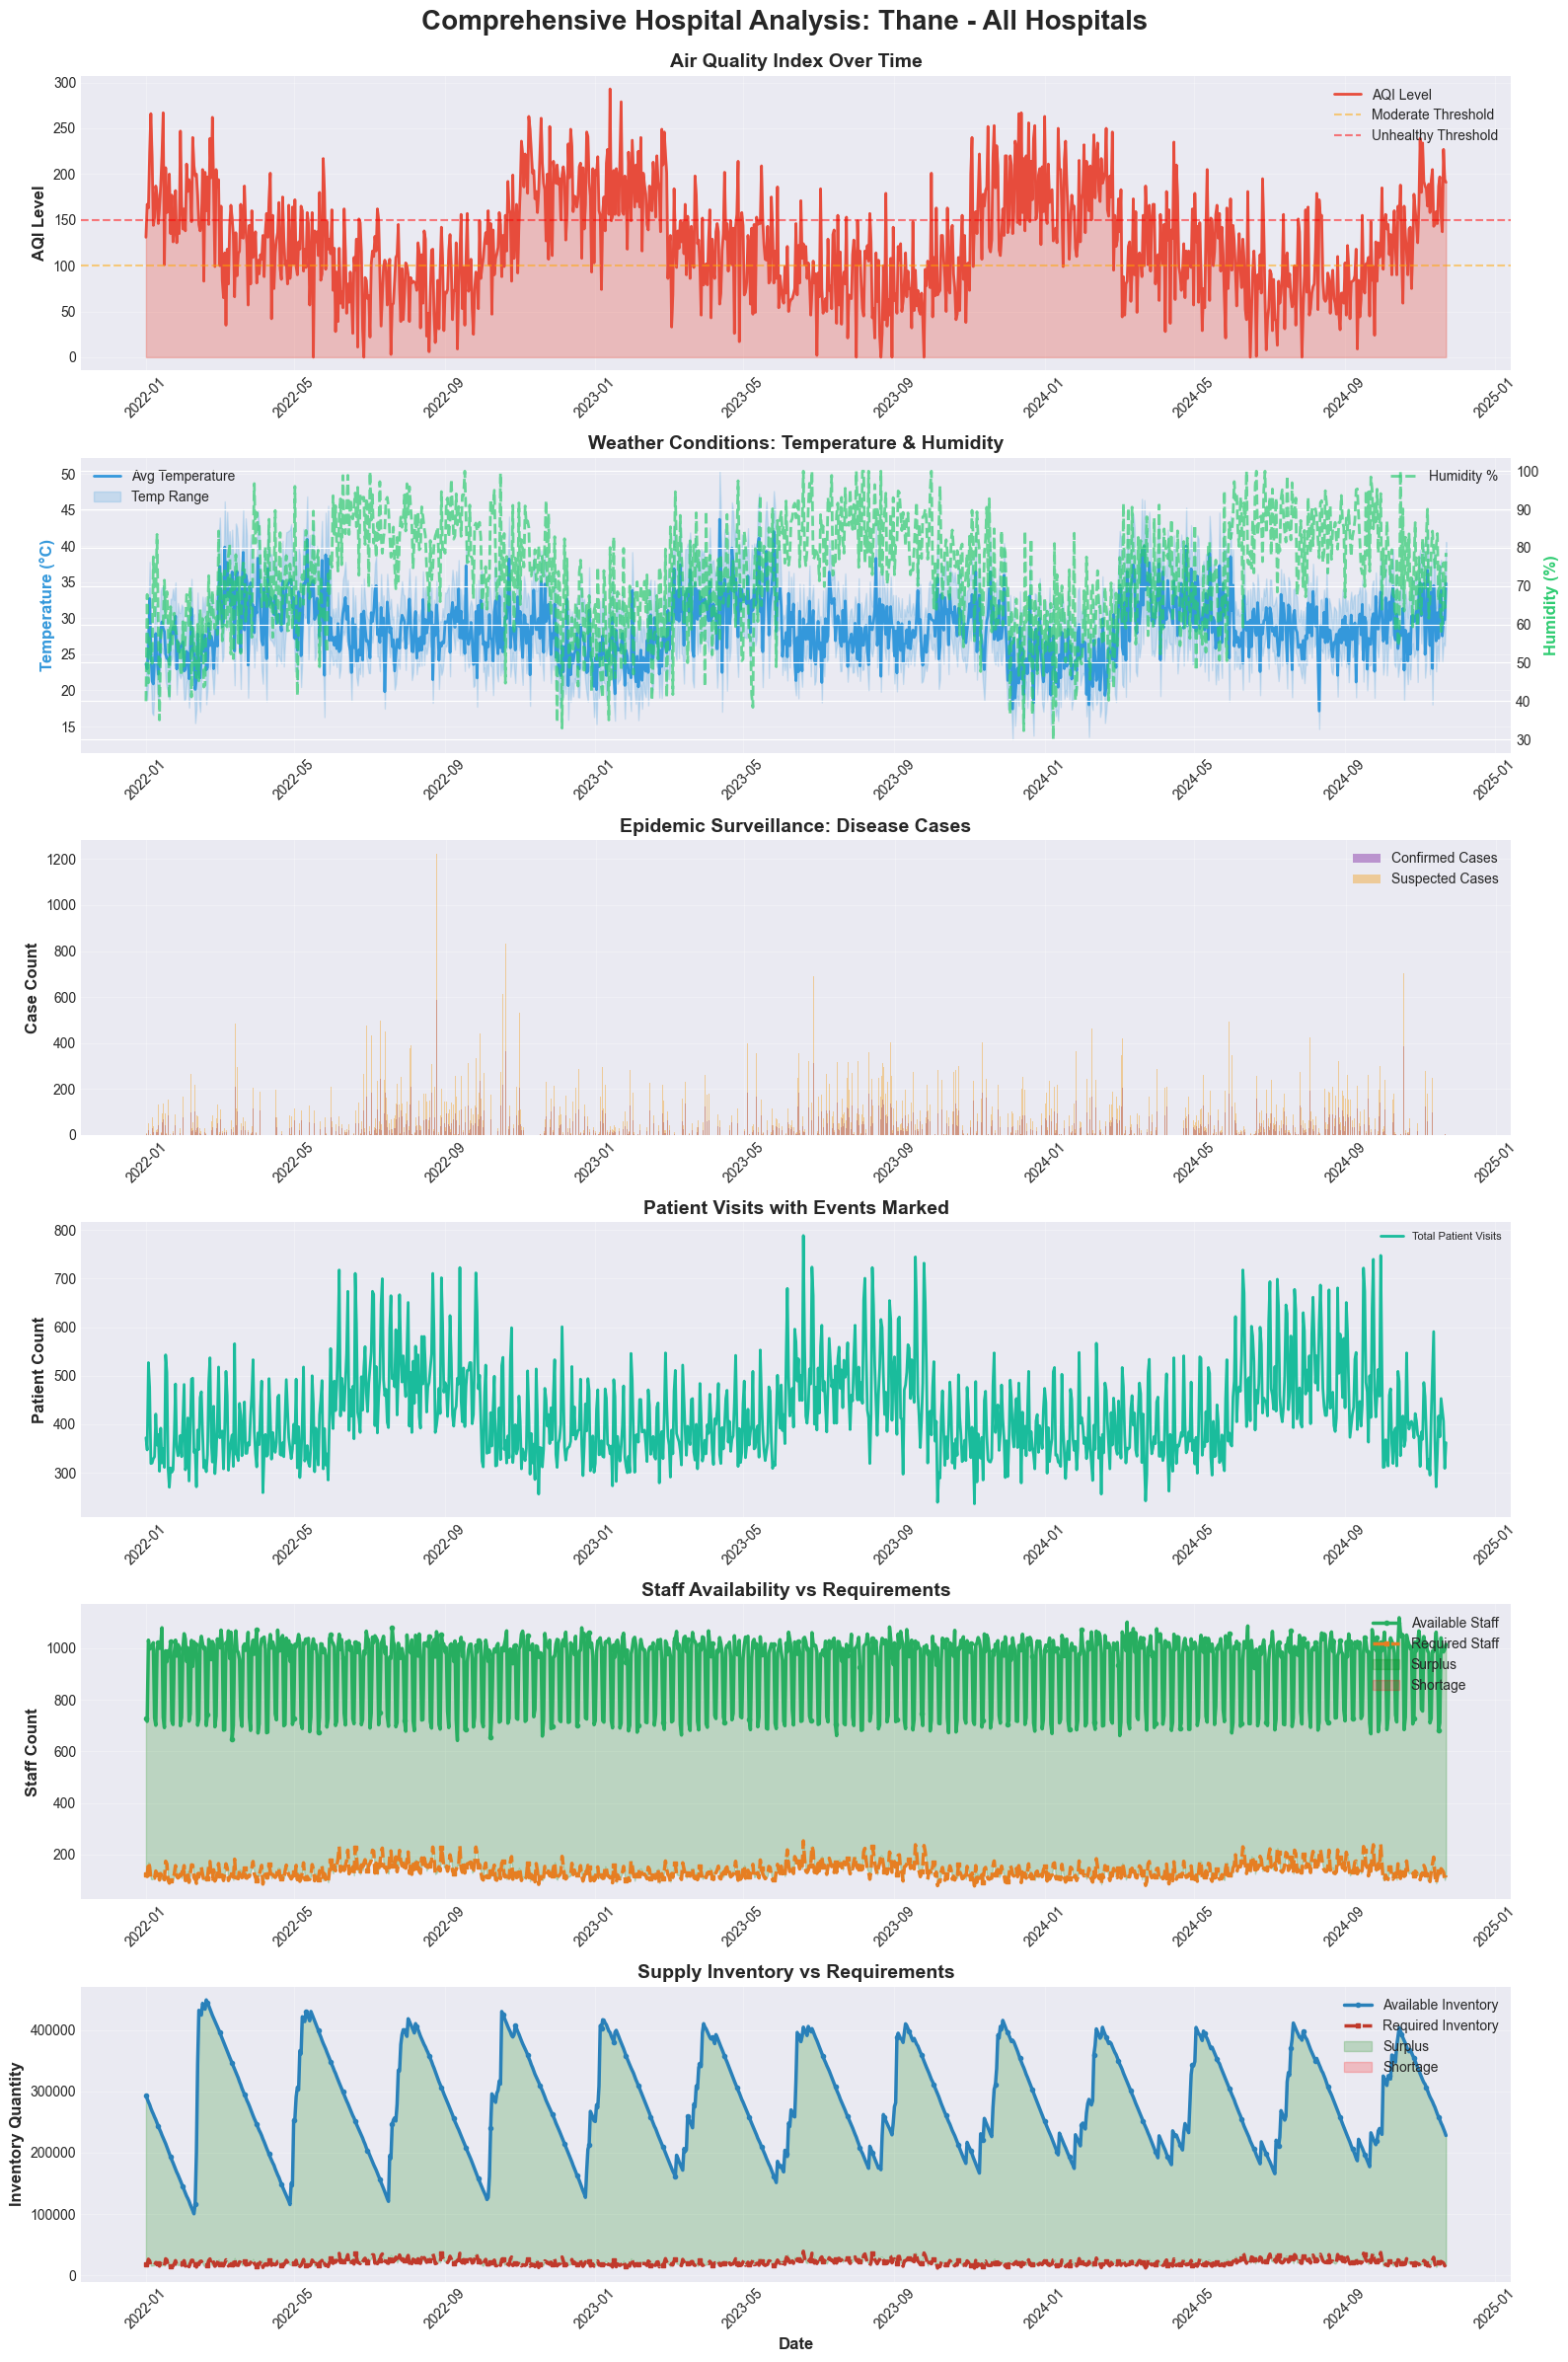

In [13]:
# Plot for Thane - All Hospitals
plot_comprehensive_analysis('Thane')

## 7. Individual Hospital Analysis
Select specific hospitals for detailed analysis

In [14]:
# List all hospitals
print("Available Hospitals:")
for idx, row in hospitals_with_location.iterrows():
    print(f"{idx+1}. {row['hospital_name']} ({row['city']})")

Available Hospitals:
1. Metro Medical Center - Mumbai Central (Mumbai)
2. District Hospital - Mumbai Central (Mumbai)
3. Apollo Hospital - Mumbai Central (Mumbai)
4. Lilavati Hospital - Mumbai Suburban (Mumbai)
5. City General Hospital - Mumbai Suburban (Mumbai)
6. Metro Medical Center - Mumbai Suburban (Mumbai)
7. District Hospital - Thane (Thane)
8. Apollo Hospital - Thane (Thane)
9. Lilavati Hospital - Pune (Pune)
10. City General Hospital - Pune (Pune)
11. Metro Medical Center - Pune (Pune)
12. District Hospital - Nashik (Nashik)
13. Apollo Hospital - Nashik (Nashik)


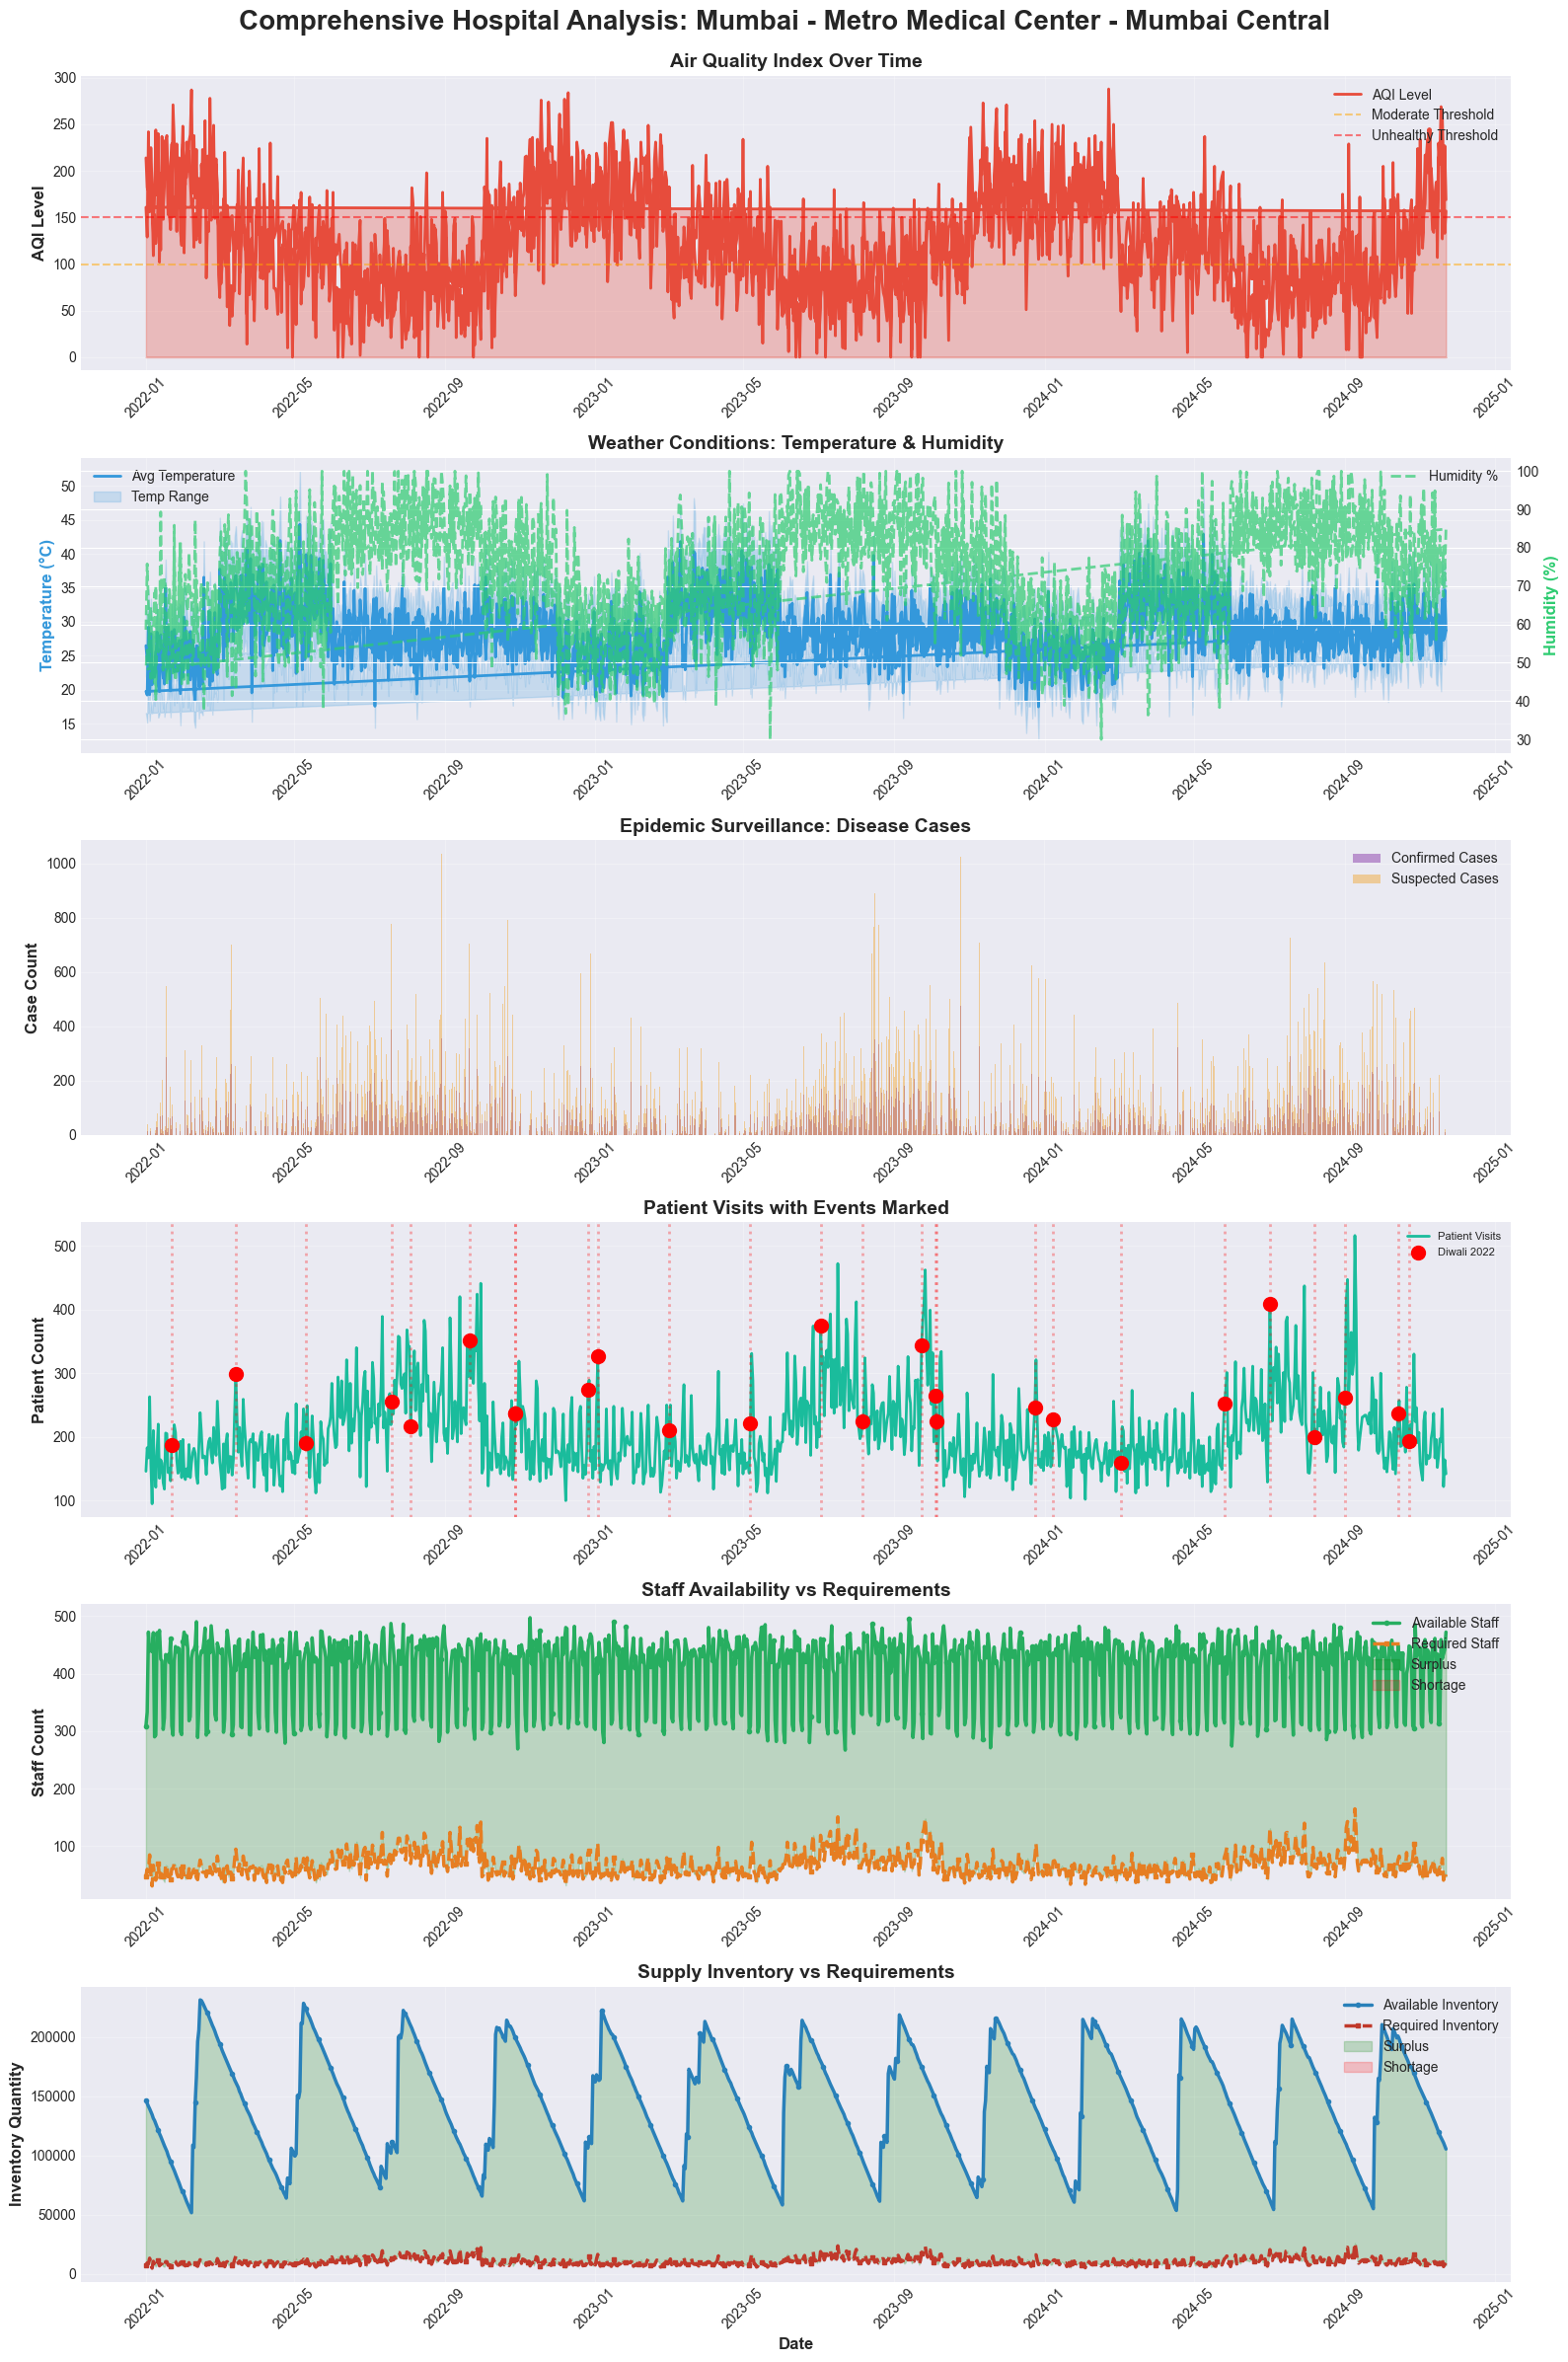

In [15]:
# Example: Plot for a specific hospital in Mumbai
mumbai_hospitals = hospitals_with_location[hospitals_with_location['city'] == 'Mumbai']['hospital_name'].tolist()
if len(mumbai_hospitals) > 0:
    plot_comprehensive_analysis('Mumbai', mumbai_hospitals[0])

## 8. Correlation Analysis
Analyze correlations between environmental factors and patient demand

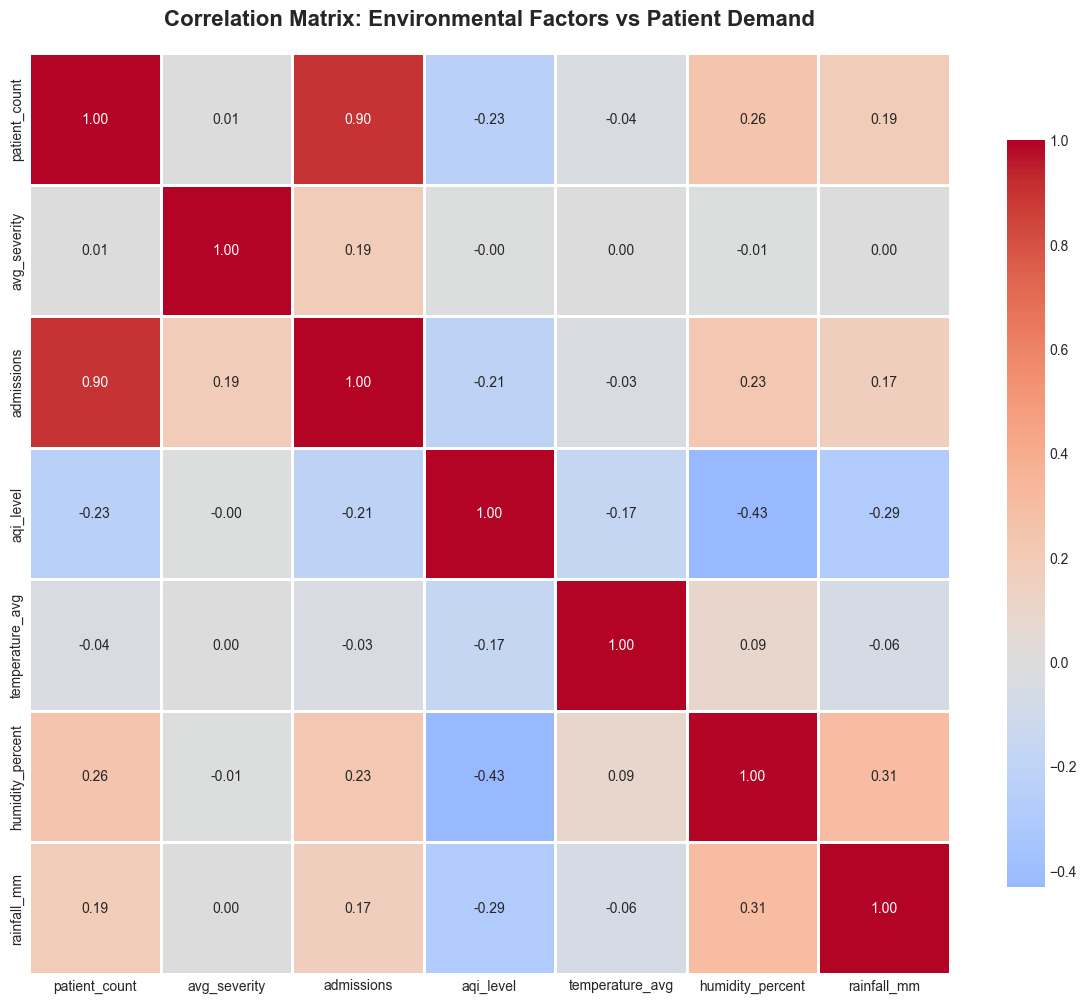


Key Correlations:
patient_count       1.000000
admissions          0.902878
humidity_percent    0.255916
rainfall_mm         0.191915
avg_severity        0.005587
temperature_avg    -0.035750
aqi_level          -0.233600
Name: patient_count, dtype: float64


In [16]:
# Merge all data for correlation analysis
correlation_data = daily_visits.merge(
    environmental_data[['record_date', 'location_id', 'aqi_level', 'temperature_avg', 'humidity_percent', 'rainfall_mm']], 
    left_on=['date', 'location_id'], 
    right_on=['record_date', 'location_id'],
    how='left'
)

# Select numeric columns for correlation
corr_columns = ['patient_count', 'avg_severity', 'admissions', 'aqi_level', 'temperature_avg', 'humidity_percent', 'rainfall_mm']
correlation_matrix = correlation_data[corr_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix: Environmental Factors vs Patient Demand', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations:")
print(correlation_matrix['patient_count'].sort_values(ascending=False))

## 9. Resource Shortage Analysis
Identify periods of staff and inventory shortages

In [17]:
# Calculate shortage metrics
staff_comparison['staff_shortage'] = staff_comparison['total_required_staff'] - staff_comparison['total_available_staff']
staff_comparison['staff_shortage_pct'] = (staff_comparison['staff_shortage'] / staff_comparison['total_required_staff'] * 100).fillna(0)

inventory_comparison['inventory_shortage'] = inventory_comparison['required_inventory'] - inventory_comparison['total_inventory_qty']
inventory_comparison['inventory_shortage_pct'] = (inventory_comparison['inventory_shortage'] / inventory_comparison['required_inventory'] * 100).fillna(0)

# Find critical shortage periods (>20% shortage)
critical_staff_shortages = staff_comparison[staff_comparison['staff_shortage_pct'] > 20].sort_values('staff_shortage_pct', ascending=False)
critical_inventory_shortages = inventory_comparison[inventory_comparison['inventory_shortage_pct'] > 20].sort_values('inventory_shortage_pct', ascending=False)

print("\n=== CRITICAL STAFF SHORTAGES (>20%) ===")
print(critical_staff_shortages[['date', 'hospital_name', 'total_available_staff', 'total_required_staff', 'staff_shortage_pct']].head(20))

print("\n=== CRITICAL INVENTORY SHORTAGES (>20%) ===")
print(critical_inventory_shortages[['date', 'hospital_name', 'total_inventory_qty', 'required_inventory', 'inventory_shortage_pct']].head(20))


=== CRITICAL STAFF SHORTAGES (>20%) ===
Empty DataFrame
Columns: [date, hospital_name, total_available_staff, total_required_staff, staff_shortage_pct]
Index: []

=== CRITICAL INVENTORY SHORTAGES (>20%) ===
Empty DataFrame
Columns: [date, hospital_name, total_inventory_qty, required_inventory, inventory_shortage_pct]
Index: []


## 10. Summary Statistics by City


=== CITY-LEVEL SUMMARY ===
       patient_count              admissions        avg_severity  \
                 sum    mean  max        sum   mean         mean   
city                                                               
Mumbai       1535002  242.04  833     184048  29.02          2.4   
Nashik        446456  211.19  489      53364  25.24          2.4   
Pune          792880  250.04  668      95129  30.00          2.4   
Thane         449270  212.52  522      54114  25.60          2.4   

       staff_shortage staff_shortage_pct  
                 mean               mean  
city                                      
Mumbai        -355.90            -528.77  
Nashik        -394.91            -669.79  
Pune          -324.47            -453.46  
Thane         -394.24            -688.92  


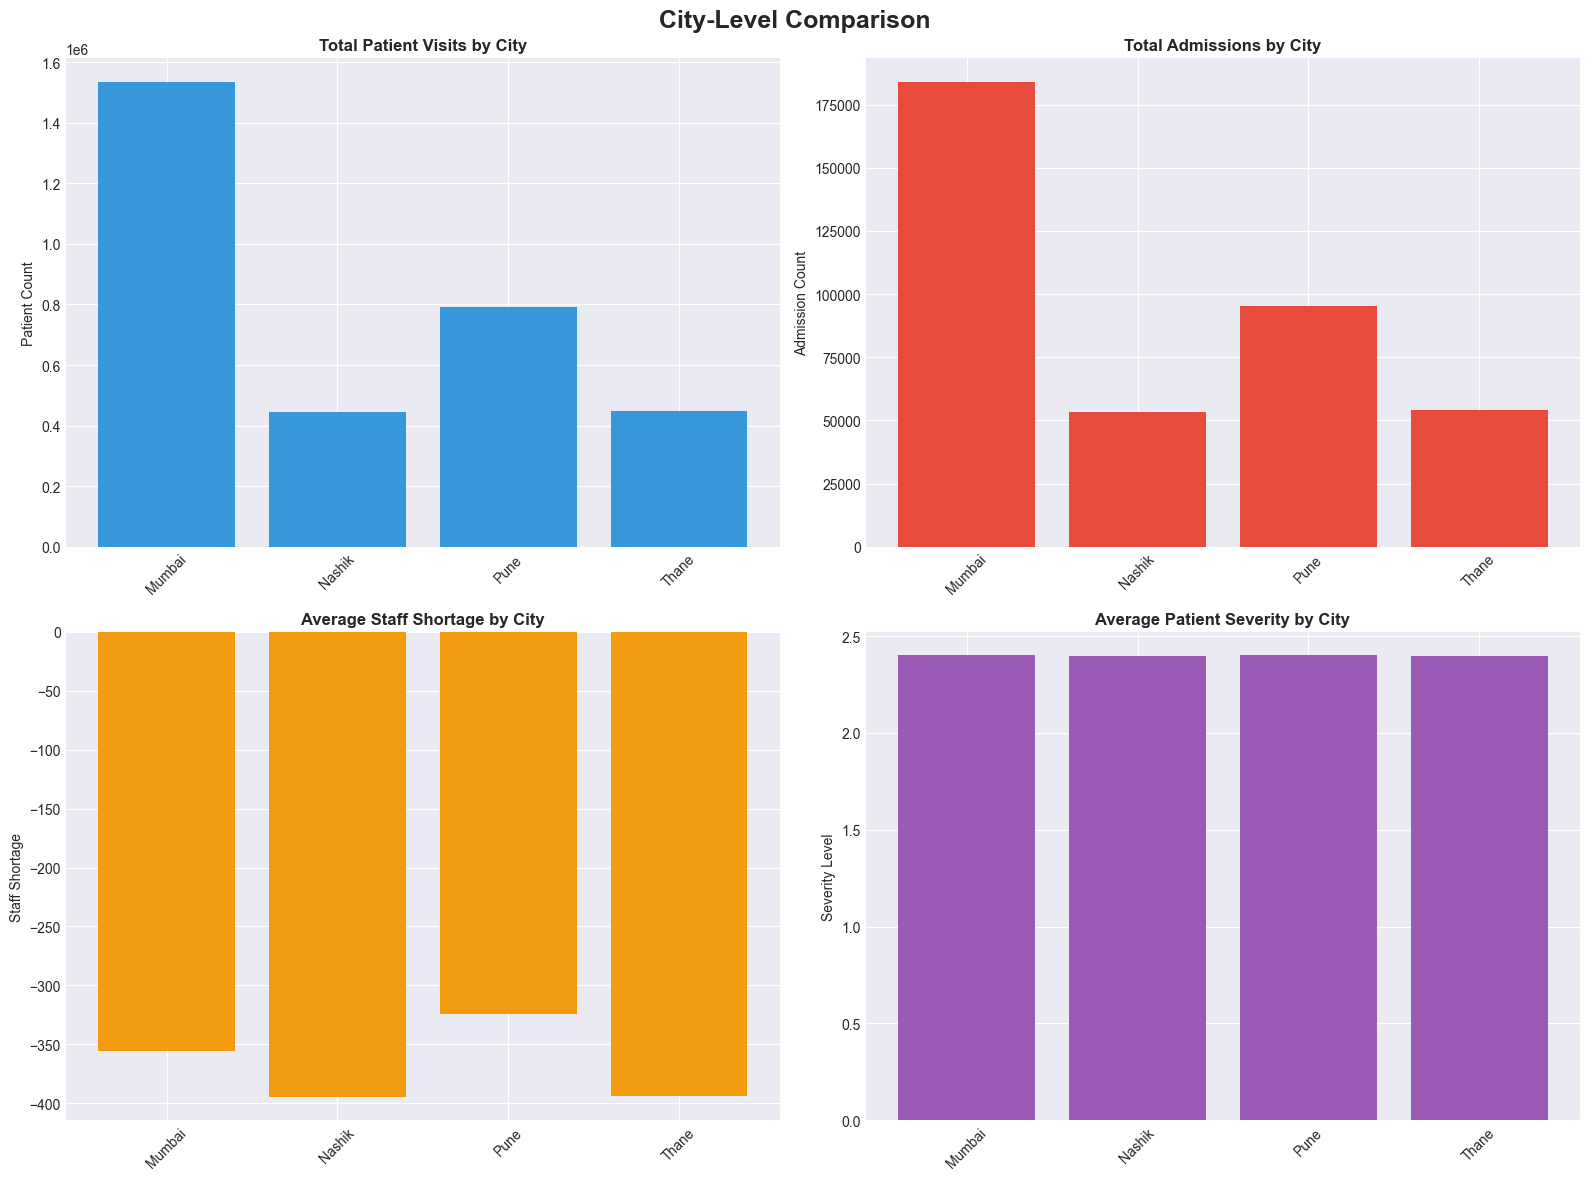

In [18]:
# Summary statistics by city
city_summary = staff_comparison.groupby('city').agg({
    'patient_count': ['sum', 'mean', 'max'],
    'admissions': ['sum', 'mean'],
    'avg_severity': 'mean',
    'staff_shortage': 'mean',
    'staff_shortage_pct': 'mean'
}).round(2)

print("\n=== CITY-LEVEL SUMMARY ===")
print(city_summary)

# Plot city comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('City-Level Comparison', fontsize=18, fontweight='bold')

city_agg = staff_comparison.groupby('city').agg({
    'patient_count': 'sum',
    'admissions': 'sum',
    'staff_shortage': 'mean',
    'avg_severity': 'mean'
}).reset_index()

# Total patients by city
axes[0, 0].bar(city_agg['city'], city_agg['patient_count'], color='#3498db')
axes[0, 0].set_title('Total Patient Visits by City', fontweight='bold')
axes[0, 0].set_ylabel('Patient Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Total admissions by city
axes[0, 1].bar(city_agg['city'], city_agg['admissions'], color='#e74c3c')
axes[0, 1].set_title('Total Admissions by City', fontweight='bold')
axes[0, 1].set_ylabel('Admission Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average staff shortage by city
axes[1, 0].bar(city_agg['city'], city_agg['staff_shortage'], color='#f39c12')
axes[1, 0].set_title('Average Staff Shortage by City', fontweight='bold')
axes[1, 0].set_ylabel('Staff Shortage')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average severity by city
axes[1, 1].bar(city_agg['city'], city_agg['avg_severity'], color='#9b59b6')
axes[1, 1].set_title('Average Patient Severity by City', fontweight='bold')
axes[1, 1].set_ylabel('Severity Level')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Export Analysis Results

In [19]:
# Export key analysis results
output_dir = './analysis_results/'
import os
os.makedirs(output_dir, exist_ok=True)

# Export shortage analysis
critical_staff_shortages.to_csv(f'{output_dir}critical_staff_shortages.csv', index=False)
critical_inventory_shortages.to_csv(f'{output_dir}critical_inventory_shortages.csv', index=False)

# Export city summary
city_summary.to_csv(f'{output_dir}city_summary.csv')

# Export correlation matrix
correlation_matrix.to_csv(f'{output_dir}correlation_matrix.csv')

print(f"\n✓ Analysis results exported to {output_dir}")


✓ Analysis results exported to ./analysis_results/
